# Experimental speckle phase retrieval

### Imports and data loading

Load the libraries

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
from scipy.io import loadmat
import mat73
import speckleret as spr

data_path = 'C:/ML/datasets/data_f_60mm_good.mat'
# data_path = 'C:/ML/datasets/data_base_CP_CL_f_60mm_2_cameras_6_6.mat'

Load the interferometric data

In [3]:
CL = loadmat(data_path)['CL']
CP = loadmat(data_path)['CP']

print(len(CL), len(CL[0]), CL[0][0].shape)
print(len(CP), len(CP[0]), CP[0][0].shape)

1 100 (512, 512)
1 100 (801, 801)


### Data cleanup: noise removal and centroid detection

Let's remove the noise from the measured far field

10.430112387527624


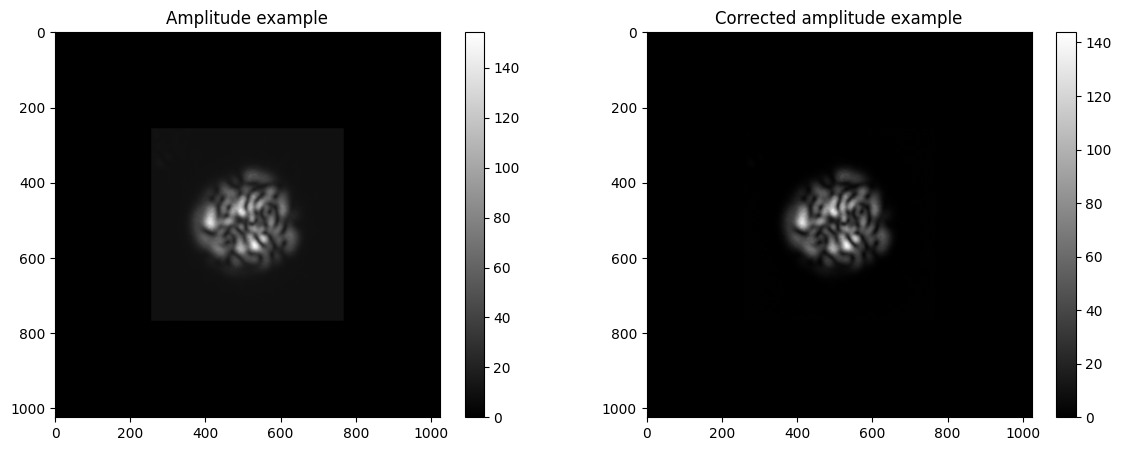

In [4]:
noise_corr = spr.utils.extract_noise_correction(CL, mask_trsh=0.02, plot_result=True)
print(noise_corr)

Let's detect the average centroids

In [5]:
centroids_CP = spr.utils.extract_average_centroid(CP)
centroids_CL = spr.utils.extract_average_centroid(CL)

print(f"Average centroid CP: {centroids_CP}")
print(f"Average centroid CL: {centroids_CL}")

Average centroid CP: (406.1723723897356, 414.1806747668517)
Average centroid CL: (252.97837852154788, 253.63111429375599)


### Data preparation

Select data for phase retrieval

In [9]:
idx = 7
random: bool = True
if random:
    idx = np.random.randint(0, len(CP[0]))

(628, 628) 36.52683611794298
(628, 628) 5373619.0


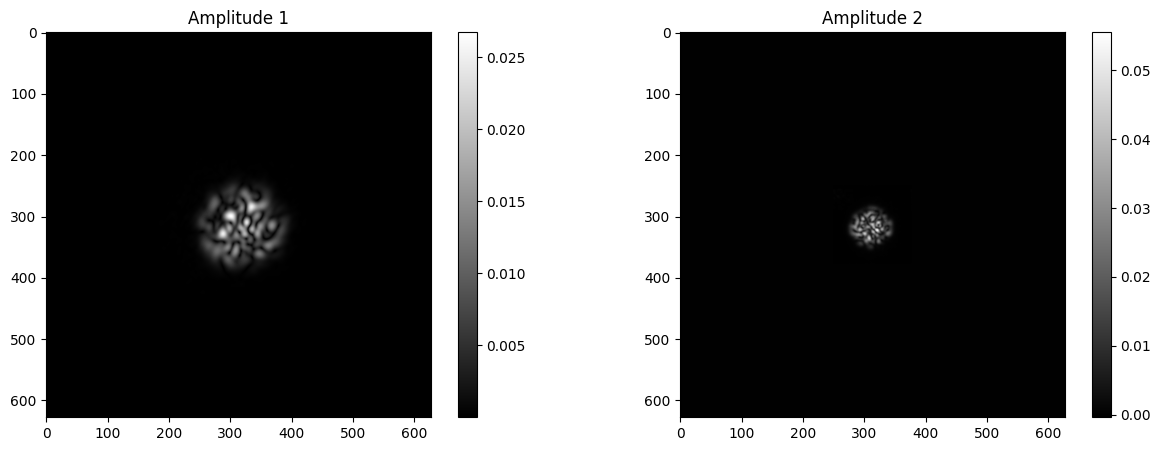

In [10]:
field = CP[0][idx]
CP_shift = (np.array(centroids_CP) - np.array(field.shape) / 2).astype(int)
field = np.roll(field, shift=-CP_shift, axis=(0,1))
# field = spr.transforms.pad_img(field, 2.139)
field = field[86:-87, 86:-87]
# field = field[:-1, :-1]

field_energy = np.sum(np.square(np.abs(field)))
field = field / np.sqrt(field_energy)
print(field.shape, field_energy)


ft = np.sqrt(CL[0][idx]) - noise_corr
CL_shift = (np.array(centroids_CL) - np.array(ft.shape) / 2).astype(int) + np.array([-20, 10])
ft = np.roll(ft, shift=-CL_shift, axis=(0,1))
ft = spr.utils.bin_image(ft, newshape=(128, 128))
# ft = ft[:-1,:-1]
# ft = spr.transforms.pad_img(ft, 3.92)
ft = spr.transforms.pad_img(ft, 3.92)

ft_energy = np.sum(np.square(np.abs(ft)))
ft = ft / np.sqrt(ft_energy)
print(ft.shape, ft_energy)

# _ = spr.plots.compare_arrays(field[1000:1500,1000:1500], ft[1000:1500,1000:1500], cmap='gray')
_ = spr.plots.compare_arrays(field, ft, cmap='gray')

Check that the Fourier transform of the field matches with the measured (perhaps resampled) one. Any shift will lead to a phase slope in the retrieved phase

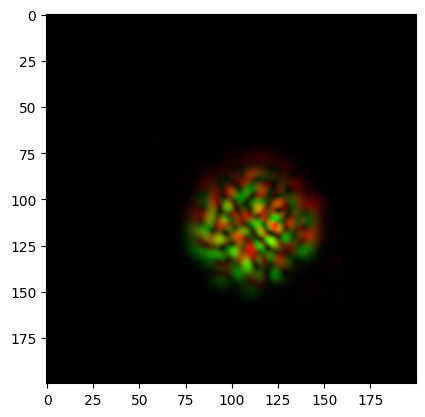

In [11]:
ft_field = spr.transforms.fourier_transform(field)
_ = spr.plots.rgb_imshow([np.abs(ft_field[200:400, 200:400]), np.abs(ft[200:400, 200:400]), None])

Define the phase retrieval support

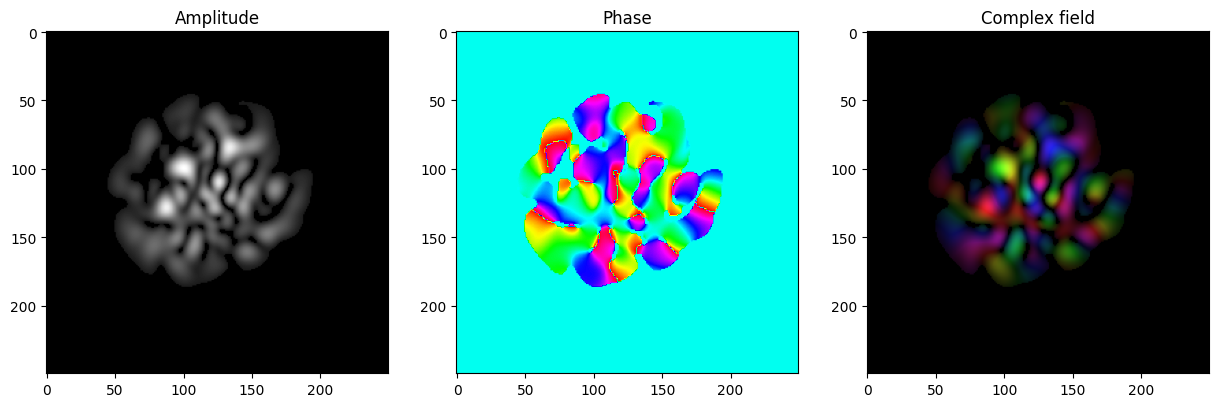

In [12]:
support = spr.supports.threshold_support(field, threshold=0.01)
supported_field = field.copy()
supported_field[np.logical_not(support)] = 0
# _ = spr.plots.complex_imshow(supported_field[1000:1500, 1000:1500])
_ = spr.plots.complex_imshow(supported_field[200:450, 200:450])

### Phase retrieval

Run the phase retrieval. From now, a good setup includes:
- Flat phases initialization
- HIO iterations to refine the phase initialization
- ER iterations to converge to the solution

Quality: 0.03304860902837054
Pearson: 1.0


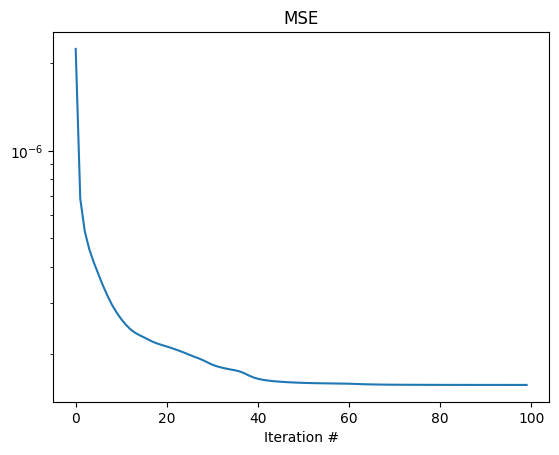

In [13]:
init = spr.initializers.flat_phases(np.abs(field))
# y_hat, ft_hat, results = spr.retrieval.hio_er_fourier((np.abs(field), np.abs(ft)), support, pad=None, init=init, beta=0.99, max_iter=1, max_er_iter=50, max_hio_iter=50)
y_hat, ft_hat, results = spr.retrieval.error_reduction_fourier((np.abs(field), np.abs(ft)), support, pad=None, init=init, max_iter=100)


print(f"Quality: {spr.metrics.quality(y_hat[support], field[support])}")
print(f"Pearson: {spr.metrics.pearson(y_hat[support], field[support])}")

plt.figure()
plt.plot(results['mse_plane2'], label='Fourier MSE')
plt.title('MSE')
plt.xlabel('Iteration #')
plt.yscale('log')

Check the results with the target, and display the phase difference with the target (it is likely to contain a phase slope due to Fourier magnitudes misalignments)

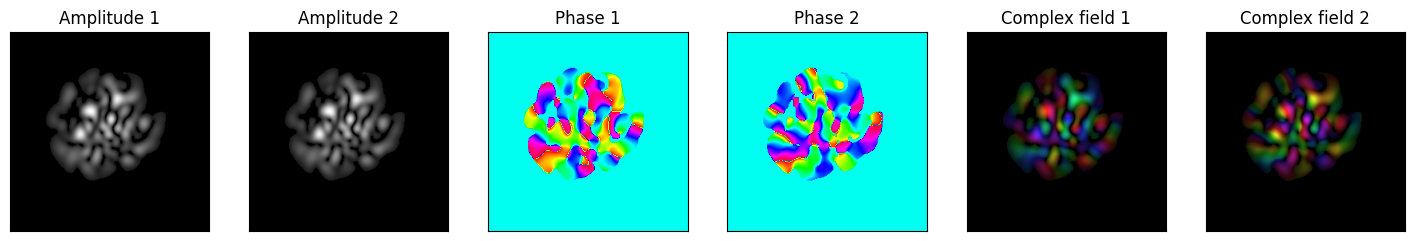

Phase error:
  - Mean: 0.11652 rad
  - Std: 2.02082 rad


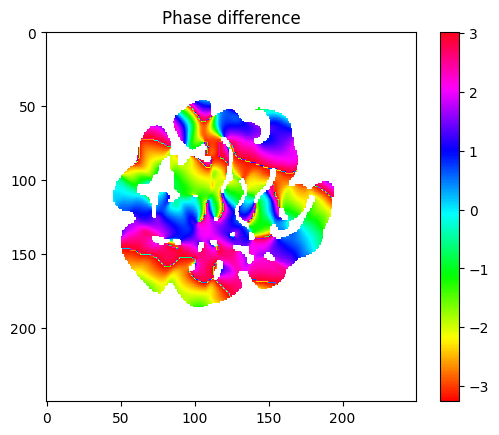

In [14]:
# _ = spr.plots.compare_complex_fields((field * support)[1100:1400, 1100:1400], (y_hat * support)[1100:1400, 1100:1400], remove_ticks=True, figsize=(18,6))
# plt.show()
# spr.plots.phase_difference(y_hat[1100:1400, 1100:1400], field[1100:1400, 1100:1400], support[1100:1400, 1100:1400])
# plt.show()


_ = spr.plots.compare_complex_fields(
    spr.transforms.apply_mask(field, support)[200:450, 200:450],
    spr.transforms.apply_mask(y_hat, support)[200:450, 200:450],
    remove_ticks=True, figsize=(18,6)
    )
plt.show()

spr.plots.phase_difference(y_hat[200:450, 200:450], field[200:450, 200:450], support[200:450, 200:450])
plt.show()

### Testing other phase retrieval algorithms !?!

There are plenty of them based on iterative projections/reflections. It seems that RAAR works well.

In [18]:
max_iter = 100
beta = 0.7

# x = spr.initializers.flat_phases(np.abs(field))
x = spr.initializers.random_phases(np.abs(field))

mse = []
quality = []
quality_phi = []

for i in range(max_iter):
    metric = spr.metrics.mse(spr.transforms.fourier_transform(x), np.abs(ft))
    q = spr.metrics.quality(x[support], field[support], inversed=True)
    q_phi = spr.metrics.quality(np.exp(1j * np.angle(x[support])), np.exp(1j * np.angle(field[support])), inversed=True)
    mse.append(metric)
    quality.append(q)
    quality_phi.append(q_phi)

    # x = speckleret.retrievalmath.ER(x=x, magnitude_S=np.abs(field), magnitude_M=np.abs(ft), support=support)
    # x = speckleret.retrievalmath.SF(x=x, magnitude_S=np.abs(field), magnitude_M=np.abs(ft), support=support)
    # x = speckleret.retrievalmath.HIO(x=x, magnitude_S=np.abs(field), magnitude_M=np.abs(ft), support=support, beta=beta)
    # x = speckleret.retrievalmath.DM(x=x, magnitude_S=np.abs(field), magnitude_M=np.abs(ft), support=support, beta=beta)
    # x = speckleret.retrievalmath.ASR(x=x, magnitude_S=np.abs(field), magnitude_M=np.abs(ft), support=support)
    # x = speckleret.retrievalmath.HPR(x=x, magnitude_S=np.abs(field), magnitude_M=np.abs(ft), support=support, beta=beta)
    x = spr.retrievalmath.RAAR(x=x, magnitude_S=np.abs(field), magnitude_M=np.abs(ft), support=support, beta=beta)

    if i == 0:
        q_best, x_best = q, x
    else:
        if q < q_best:
            q_best, x_best = q, x

Qualities:	 Last = 0.00158,	 Last_phi = 0.02192,	 Best = 0.02844,	 Best_phi = 0.01099
Pearsons: 	 Last = 0.97919,	 Best = 0.94818


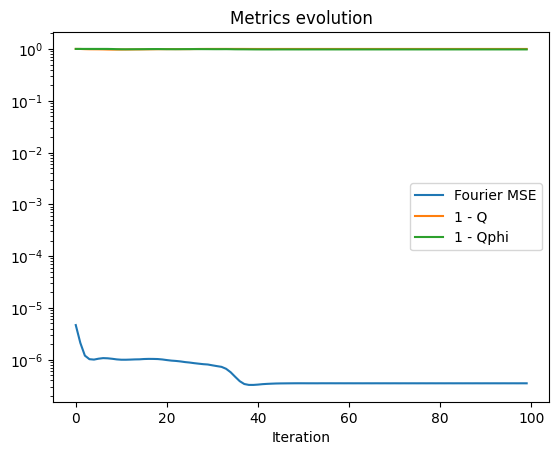

In [19]:
q_best_phi = spr.metrics.quality(np.exp(1j * np.angle(x_best[support])), np.exp(1j * np.angle(field[support])))
pearson = spr.metrics.pearson(x[support], field[support])
pearson_best = spr.metrics.pearson(x_best[support], field[support])

print(f"Qualities:\t Last = {1-q:3.5f},\t Last_phi = {1-q_phi:3.5f},\t Best = {1-q_best:3.5f},\t Best_phi = {q_best_phi:3.5f}")
print(f"Pearsons: \t Last = {pearson:3.5f},\t Best = {pearson_best:3.5f}")

plt.figure()
plt.plot(mse, label='Fourier MSE')
plt.plot(quality, label='1 - Q')
plt.plot(quality_phi, label='1 - Qphi')
plt.yscale('log')
plt.title('Metrics evolution')
plt.xlabel('Iteration')
plt.legend()

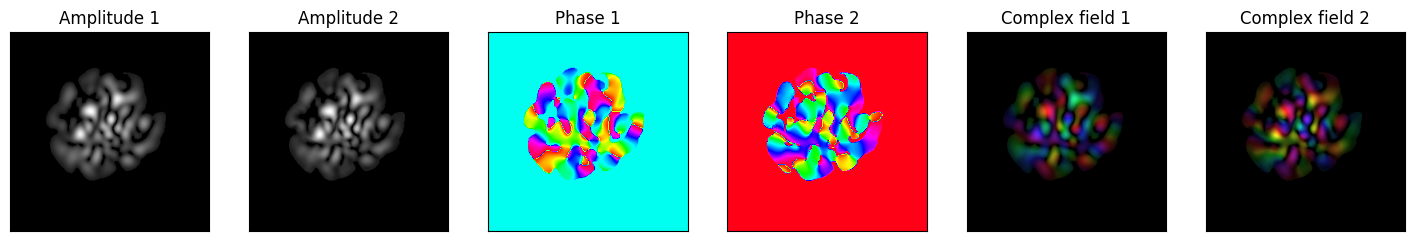

Phase error:
  - Mean: 0.05893 rad
  - Std: 1.61968 rad


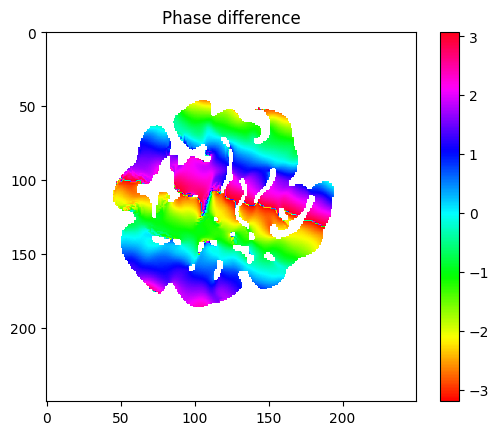

In [20]:
_ = spr.plots.compare_complex_fields(
    spr.transforms.apply_mask(field, support)[200:450, 200:450],
    spr.transforms.apply_mask(x, support)[200:450, 200:450],
    remove_ticks=True, figsize=(18,6)
    )
plt.show()

spr.plots.phase_difference(x[200:450, 200:450], field[200:450, 200:450], support[200:450, 200:450])
plt.show()